In [1]:
import nibabel as nib
from totalsegmentator.python_api import totalsegmentator
import os
import SimpleITK as sitk
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import numpy as np
from image_utils import convert_series_to_nifti, quantize_maps, quantize_maps_top_quarter, clear_directory, convert_and_copy_with_labels_and_rename, generate_dataset_json
import logging
from image_utils import ImageVisualizer, show_progress
from skimage.restoration import inpaint

#DATASET_NUM = "041"
FOLD_NUM = 0

In [ ]:
"""
fixed_images_dir = "/mnt/d/CTH_archive/CTH_STRIPPED"  
moving_images_dir = "/mnt/d/CTH_archive/CTP_STRIPPED" 


transforms_dir =  "/mnt/d/CTH_archive/CTH_TMAX_TRANSFORMS_COLOR"
transformed_img_dir = "/mnt/d/CTH_archive/CTH_STRIPPED_REG_COLOR"


def register_images(fixed_image_path, moving_image_path, transforms_dir):
    # Extract patient identifier from the file name, ensuring .nii is not included
    patient = os.path.splitext(os.path.basename(moving_image_path))[0]
    patient = os.path.splitext(patient)[0]  # Remove .nii if present

    # Construct the transform file path
    transform_file = os.path.join(transforms_dir, f'{patient}.h5')

    # Check if the transform file already exists and skip registration if it does
    if os.path.exists(transform_file):
        print(f"Transform file already exists for patient {patient}, skipping registration.")
        return

    # Load the fixed and moving images
    fixed_image = sitk.ReadImage(fixed_image_path)
    moving_image = sitk.ReadImage(moving_image_path)

    # Initialize the registration method
    registration_method = sitk.ImageRegistrationMethod()
    registration_method.SetMetricAsMattesMutualInformation(numberOfHistogramBins=50)
    registration_method.SetMetricSamplingPercentage(0.10)
    registration_method.SetMetricSamplingStrategy(registration_method.RANDOM)
    registration_method.SetOptimizerAsGradientDescentLineSearch(learningRate=0.5, numberOfIterations=500)
    registration_method.SetOptimizerScalesFromPhysicalShift()
    registration_method.SetShrinkFactorsPerLevel(shrinkFactors=[8, 4, 2])
    registration_method.SetSmoothingSigmasPerLevel(smoothingSigmas=[4, 2, 1])
    registration_method.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

    initial_transform = sitk.CenteredTransformInitializer(sitk.Cast(fixed_image, moving_image.GetPixelID()), 
                                                      moving_image, 
                                                      sitk.AffineTransform(fixed_image.GetDimension()),
                                                      sitk.CenteredTransformInitializerFilter.MOMENTS)
    
    registration_method.SetInitialTransform(initial_transform, True)

    try:
        # Execute the registration
        final_transform = registration_method.Execute(fixed_image, moving_image)
        
        # Save the transform
        sitk.WriteTransform(final_transform, transform_file)
        sitk.WriteImage(sitk.Resample(moving_image, fixed_image, final_transform,  sitk.sitkNearestNeighbor), f"{transformed_img_dir}/{patient}.nii")
        print("Final metric value: {0}".format(registration_method.GetMetricValue()))
        print(
            "Optimizer's stopping condition, {0}".format(
                registration_method.GetOptimizerStopConditionDescription()
            )
        )
        print(f"Registration successful for patient: {patient}. Transform saved to {transform_file}")
    except RuntimeError as e:
        print(f"Registration failed for patient {patient}: {e}")


for filename in tqdm(os.listdir(fixed_images_dir)):
    fixed_image_path = os.path.join(fixed_images_dir, filename)
    moving_image_path = os.path.join(moving_images_dir, filename)

    if os.path.isfile(fixed_image_path) and os.path.isfile(moving_image_path):
        if not os.path.exists(transforms_dir):
            os.makedirs(transforms_dir, exist_ok=True)
        register_images(fixed_image_path, moving_image_path, transforms_dir)"""

In [ ]:
import os
import shutil
import pydicom

# Define the root directory and output directory
root_dir = '/mnt/d/CTH_archive/DICOM/'
output_root_dir = '/mnt/d/CTH_archive/CBF_COLORED'

# Define the target series descriptions
primary_series = "VIZ CBF COLORED"
secondary_series = "VIZ CBF"

# Function to copy a DICOM file to the output directory
def copy_dicom_file(filepath, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    shutil.copy2(filepath, output_dir)
    print(f"Copied {os.path.basename(filepath)} to {output_dir}")

# Process each patient directory
for patient_name in os.listdir(root_dir):
    patient_dir = os.path.join(root_dir, patient_name)
    if os.path.isdir(patient_dir):
        print(f"Processing {patient_name}...")
        
        primary_found = False
        
        # First, search for and copy primary series
        for dirpath, _, filenames in os.walk(patient_dir):
            for filename in filenames:
                if filename.lower().endswith(".dcm"):
                    filepath = os.path.join(dirpath, filename)
                    try:
                        dicom_file = pydicom.dcmread(filepath)
                        if 'SeriesDescription' in dicom_file and dicom_file.SeriesDescription == primary_series:
                            output_dir = os.path.join(output_root_dir, patient_name)
                            copy_dicom_file(filepath, output_dir)
                            primary_found = True
                    except Exception as e:
                        print(f"Could not process file {filepath}: {e}")
        
        # If no primary series was found, search for and copy secondary series
        if not primary_found:
            print(f"No primary series found for {patient_name}, searching for secondary series...")
            for dirpath, _, filenames in os.walk(patient_dir):
                for filename in filenames:
                    if filename.lower().endswith(".dcm"):
                        filepath = os.path.join(dirpath, filename)
                        try:
                            dicom_file = pydicom.dcmread(filepath)
                            if 'SeriesDescription' in dicom_file and dicom_file.SeriesDescription == secondary_series:
                                output_dir = os.path.join(output_root_dir, patient_name)
                                copy_dicom_file(filepath, output_dir)
                        except Exception as e:
                            print(f"Could not process file {filepath}: {e}")

print("Processing complete.")


In [ ]:
import os
import pydicom
import numpy as np
import SimpleITK as sitk

def convert_dicom_series_to_nii(dicom_dir, output_dir):
    # Get patient name and ID from the directory name
    patient_name_id = os.path.basename(dicom_dir)

    # Load DICOM series
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir)
    reader.SetFileNames(dicom_names)

    # Read the image series
    image = reader.Execute()

    # Ensure the output image has RGB channels
    image_array = sitk.GetArrayFromImage(image)  # shape: (slices, height, width)
    if image_array.ndim == 3:  # Single channel, need to convert to RGB
        rgb_image_array = np.stack((image_array,) * 3, axis=-1)  # shape: (slices, height, width, 3)
    else:
        rgb_image_array = image_array

    # Resize to 256x256 if necessary
    original_size = rgb_image_array.shape[1:3]
    if original_size != (256, 256):
        resized_image_array = np.zeros((rgb_image_array.shape[0], 256, 256, 3), dtype=rgb_image_array.dtype)
        for i in range(rgb_image_array.shape[0]):
            slice_image = sitk.GetImageFromArray(rgb_image_array[i])
            resized_slice = sitk.Resample(slice_image, [256, 256], sitk.Transform(), sitk.sitkLinear)
            resized_image_array[i] = sitk.GetArrayFromImage(resized_slice)
    else:
        resized_image_array = rgb_image_array

    # Create SimpleITK image from RGB array
    rgb_image = sitk.GetImageFromArray(resized_image_array)
    rgb_image.CopyInformation(image)  # Preserve orientation, direction, origin

    # Save as .nii file
    output_file = os.path.join(output_dir, f"{patient_name_id}.nii")
    sitk.WriteImage(rgb_image, output_file)

    print(f"Converted {patient_name_id} to {output_file}")

def process_all_dicom_series(base_dir, output_dir):
    # Recursively find all patient directories
    for root, dirs, files in os.walk(base_dir):
        if any(file.endswith('.dcm') for file in files):
            convert_dicom_series_to_nii(root, output_dir)

# Directory paths
base_dir = "/mnt/d/CTH_archive/CBF_COLORED"
output_dir = "/mnt/d/CTH_archive/CBF_COLORED_NIFTI"

# Convert all series in the base directory
process_all_dicom_series(base_dir, output_dir)


In [ ]:
import nibabel as nib
import numpy as np
import cv2
import os
import shutil
from tqdm import tqdm
import logging
import re

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def create_rectangle_mask(image_shape, top_left, bottom_right):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    cv2.rectangle(mask, top_left, bottom_right, 255, -1)
    return mask

def sanitize_filename(filename):
    return re.sub(r'[^a-zA-Z0-9_.-]', '_', filename)

def remove_text_and_inpaint(nii_path, output_path):
    logging.info(f"Processing file: {os.path.basename(nii_path)}")
    logging.info(f"Output path: {output_path}")
    
    if not os.path.exists(nii_path):
        raise FileNotFoundError(f"Input file not found: {nii_path}")

    nii_img = nib.load(nii_path)
    data = nii_img.get_fdata()
    assert data.shape[3:] == (1, 3), f"Unexpected data shape: {data.shape}"

    top_left = (67, 205)
    bottom_right = (43, 267)
    mask = create_rectangle_mask(data.shape[:2], top_left, bottom_right)

    for i in range(data.shape[2]):
        slice_rgb = data[:, :, i, 0, :]
        if slice_rgb.max() > 1:
            slice_rgb = slice_rgb / 255.0
        slice_uint8 = (slice_rgb * 255).astype(np.uint8)
        result_uint8 = cv2.inpaint(slice_uint8, mask, 3, cv2.INPAINT_TELEA)
        result = result_uint8.astype(float) / 255.0
        data[:, :, i, 0, :] = result

    data = np.clip(data, 0, 1)
    data = data.astype(np.float32)
    new_img = nib.Nifti1Image(data, nii_img.affine, header=nii_img.header)
    new_img.set_data_dtype(np.float32)

    os.makedirs(os.path.dirname(output_path), exist_ok=True)

    logging.info(f"Saving processed file to: {output_path}")
    try:
        nib.save(new_img, output_path)
        logging.info(f"File saved successfully: {output_path}")
    except Exception as e:
        logging.error(f"Error saving file: {str(e)}")
        alternative_output_path = os.path.join(os.path.dirname(output_path), sanitize_filename(os.path.basename(output_path)))
        logging.info(f"Attempting to save with sanitized filename: {alternative_output_path}")
        try:
            nib.save(new_img, alternative_output_path)
            logging.info(f"File saved successfully with sanitized filename: {alternative_output_path}")
        except Exception as e2:
            logging.error(f"Error saving file with sanitized filename: {str(e2)}")
            logging.info("Attempting to copy the original file")
            try:
                shutil.copy2(nii_path, output_path)
                logging.info(f"Copied original file to: {output_path}")
            except Exception as e3:
                logging.error(f"Error copying original file: {str(e3)}")
                raise

def process_all_nifti_files(input_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    
    nii_files = [f for f in os.listdir(input_dir) if f.endswith('.nii')]
    
    for nii_file in tqdm(nii_files, desc="Processing NIfTI files"):
        input_path = os.path.join(input_dir, nii_file)
        output_path = os.path.join(output_dir, nii_file)
        try:
            remove_text_and_inpaint(input_path, output_path)
        except Exception as e:
            logging.error(f"Error processing {nii_file}: {str(e)}")
            if nii_file == "CLARKSON-FARRELL_EDWARD.nii":
                logging.error(f"Detailed error for CLARKSON-FARRELL_EDWARD.nii:")
                logging.error(f"Input path: {input_path}")
                logging.error(f"Output path: {output_path}")
                logging.error(f"Input path exists: {os.path.exists(input_path)}")
                logging.error(f"Output directory exists: {os.path.exists(os.path.dirname(output_path))}")
                logging.error(f"Can write to output directory: {os.access(os.path.dirname(output_path), os.W_OK)}")
                logging.error(f"File permissions of input file: {oct(os.stat(input_path).st_mode)[-3:]}")
                logging.error(f"File permissions of output directory: {oct(os.stat(os.path.dirname(output_path)).st_mode)[-3:]}")
                
                # Try to list the contents of the output directory
                try:
                    logging.info(f"Contents of output directory: {os.listdir(os.path.dirname(output_path))}")
                except Exception as dir_error:
                    logging.error(f"Error listing output directory contents: {str(dir_error)}")

# Usage
input_dir = '/mnt/d/CTH_archive/CBF_COLORED_NIFTI_RESIZED_Processed'
output_dir = '/mnt/d/CTH_archive/CBF_COLORED_NIFIT_NOTEXT'

process_all_nifti_files(input_dir, output_dir)

In [2]:
import SimpleITK as sitk
import os

def resize_to_512_if_needed(input_path, output_path):
    # Read the image
    image = sitk.ReadImage(input_path)
    
    # Get current size
    size = image.GetSize()
    
    # Check if resizing is needed
    if size[0] != 512 or size[1] != 512:
        # Create a resampler
        resampler = sitk.ResampleImageFilter()
        resampler.SetInterpolator(sitk.sitkLinear)
        resampler.SetOutputDirection(image.GetDirection())
        resampler.SetOutputOrigin(image.GetOrigin())
        
        # Calculate new spacing to maintain physical size
        old_spacing = image.GetSpacing()
        new_spacing = [
            old_spacing[0] * (size[0] / 512),
            old_spacing[1] * (size[1] / 512),
            old_spacing[2]
        ]
        resampler.SetOutputSpacing(new_spacing)
        
        # Set new size
        new_size = [512, 512, size[2]]
        resampler.SetSize(new_size)
        
        # Resample image
        resampled_image = resampler.Execute(image)
        
        # Save resampled image
        sitk.WriteImage(resampled_image, output_path)
        print(f"Resized and saved: {output_path}")
    else:
        # If no resizing needed, just copy the file
        sitk.WriteImage(image, output_path)
        print(f"No resizing needed, copied: {output_path}")

def process_directory(input_dir, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    
    # Process each .nii file in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith('.nii'):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            resize_to_512_if_needed(input_path, output_path)

if __name__ == "__main__":
    input_dir = r"/mnt/d/CTH_archive/CBF_COLORED_NIFIT_NOTEXT"
    output_dir = r"/mnt/d/CTH_archive/CBF_COLORED_NIFIT_NOTEXT_512"
    
    process_directory(input_dir, output_dir)
    print("Processing complete.")

No resizing needed, copied: /mnt/d/CTH_archive/CBF_COLORED_NIFIT_NOTEXT_512/ALFORD_BARBARA.nii
No resizing needed, copied: /mnt/d/CTH_archive/CBF_COLORED_NIFIT_NOTEXT_512/ALLAH_MAJUSTICE.nii
No resizing needed, copied: /mnt/d/CTH_archive/CBF_COLORED_NIFIT_NOTEXT_512/BATTLE_MARIA.nii
No resizing needed, copied: /mnt/d/CTH_archive/CBF_COLORED_NIFIT_NOTEXT_512/BAUM_ROBERT.nii
No resizing needed, copied: /mnt/d/CTH_archive/CBF_COLORED_NIFIT_NOTEXT_512/BILLIPS_JAMES.nii
No resizing needed, copied: /mnt/d/CTH_archive/CBF_COLORED_NIFIT_NOTEXT_512/BOGER_DAVID_S.nii
No resizing needed, copied: /mnt/d/CTH_archive/CBF_COLORED_NIFIT_NOTEXT_512/CAMPAGNA_HARRY_D.nii
No resizing needed, copied: /mnt/d/CTH_archive/CBF_COLORED_NIFIT_NOTEXT_512/CARDIN_PAUL.nii
No resizing needed, copied: /mnt/d/CTH_archive/CBF_COLORED_NIFIT_NOTEXT_512/CHANG_WAH_KONG.nii
No resizing needed, copied: /mnt/d/CTH_archive/CBF_COLORED_NIFIT_NOTEXT_512/CHEN_QIAOYING.nii
No resizing needed, copied: /mnt/d/CTH_archive/CBF_COLORED

In [12]:
import SimpleITK as sitk
import numpy as np
import os
from scipy import ndimage

def resize_and_match_properties(color_image_path, grayscale_image_path, output_path):
    # Read the color and grayscale images
    color_image = sitk.ReadImage(color_image_path)
    grayscale_image = sitk.ReadImage(grayscale_image_path)

    # Convert to numpy arrays
    color_array = sitk.GetArrayFromImage(color_image)
    grayscale_array = sitk.GetArrayFromImage(grayscale_image)

    # Get the target size
    target_size = grayscale_array.shape

    # Resize the color image array
    resized_color_array = np.zeros(target_size + (3,), dtype=color_array.dtype)
    for i in range(3):  # For each color channel
        resized_color_array[..., i] = ndimage.zoom(color_array[..., i], 
                                                   (target_size[0] / color_array.shape[0],
                                                    target_size[1] / color_array.shape[1],
                                                    target_size[2] / color_array.shape[2]))

    # Flip the image along the anterior-posterior axis (assuming it's the second axis)
    #resized_color_array = np.flip(resized_color_array, axis=1)

    # Create a new SimpleITK image from the resized and flipped array
    resized_color_image = sitk.GetImageFromArray(resized_color_array, isVector=True)

    # Copy all properties from the grayscale image
    resized_color_image.CopyInformation(grayscale_image)

    # Save the resized, flipped, and matched color image
    sitk.WriteImage(resized_color_image, output_path)

def process_directory(color_dir, grayscale_dir, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Process each .nii file in the color directory
    for filename in os.listdir(color_dir):
        if filename.endswith('.nii'):
            color_path = os.path.join(color_dir, filename)
            grayscale_path = os.path.join(grayscale_dir, filename)
            output_path = os.path.join(output_dir, filename)

            if os.path.exists(grayscale_path):
                print(f"Processing {filename}...")
                resize_and_match_properties(color_path, grayscale_path, output_path)
                print(f"Saved processed file to {output_path}")
            else:
                print(f"Warning: No matching grayscale file found for {filename}")

if __name__ == "__main__":
    color_dir = "/mnt/d/CTH_archive/CBF_COLORED_NIFIT_NOTEXT_512"
    grayscale_dir = "/mnt/d/CTH_archive/TMAX_NIFTI_512"
    output_dir = "/mnt/d/CTH_archive//CBF_COLORED_NIFTI_RESIZED_Processed"

    process_directory(color_dir, grayscale_dir, output_dir)
    print("Processing complete.")

Processing ALFORD_BARBARA.nii...
Saved processed file to /mnt/d/CTH_archive//CBF_COLORED_NIFTI_RESIZED_Processed/ALFORD_BARBARA.nii
Processing ALLAH_MAJUSTICE.nii...
Saved processed file to /mnt/d/CTH_archive//CBF_COLORED_NIFTI_RESIZED_Processed/ALLAH_MAJUSTICE.nii
Processing BATTLE_MARIA.nii...
Saved processed file to /mnt/d/CTH_archive//CBF_COLORED_NIFTI_RESIZED_Processed/BATTLE_MARIA.nii
Processing BAUM_ROBERT.nii...
Saved processed file to /mnt/d/CTH_archive//CBF_COLORED_NIFTI_RESIZED_Processed/BAUM_ROBERT.nii
Processing BILLIPS_JAMES.nii...
Saved processed file to /mnt/d/CTH_archive//CBF_COLORED_NIFTI_RESIZED_Processed/BILLIPS_JAMES.nii
Processing BOGER_DAVID_S.nii...
Saved processed file to /mnt/d/CTH_archive//CBF_COLORED_NIFTI_RESIZED_Processed/BOGER_DAVID_S.nii
Processing CAMPAGNA_HARRY_D.nii...
Saved processed file to /mnt/d/CTH_archive//CBF_COLORED_NIFTI_RESIZED_Processed/CAMPAGNA_HARRY_D.nii
Processing CARDIN_PAUL.nii...
Saved processed file to /mnt/d/CTH_archive//CBF_COLORE

In [3]:
import os
import logging
import SimpleITK as sitk
import numpy as np
from matplotlib import cm

FINAL_SIZE = 512 

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

import os
import numpy as np
from matplotlib import cm
import SimpleITK as sitk

import SimpleITK as sitk
import numpy as np

def process_3d_rgb_image(image):
    try:
        # Convert SimpleITK image to numpy array
        array = sitk.GetArrayFromImage(image)
        
        # Ensure the array is in the correct shape (depth, height, width, channels)
        if array.shape[-1] != 3:
            array = np.moveaxis(array, 0, -1)
        
        # Normalize the array to 0-255 range if it's not already
        if array.max() <= 1.0:
            array = (array * 255).astype(np.uint8)
        
        # Convert back to SimpleITK image (RGB)
        processed_image = sitk.GetImageFromArray(array, isVector=True)
        
        # Set metadata for the new image
        processed_image.SetSpacing(image.GetSpacing())
        processed_image.SetDirection(image.GetDirection())
        processed_image.SetOrigin(image.GetOrigin())
        
        return processed_image
    except Exception as e:
        logging.error(f"Error in process_3d_rgb_image: {str(e)}")
        logging.error(f"Image shape: {image.GetSize()}, Pixel type: {image.GetPixelID()}")
        logging.exception("Stack trace:")
        raise
    
def resample_image(moving_image, ctp_image):
    desired_size = [FINAL_SIZE, FINAL_SIZE, ctp_image.GetSize()[2]]  # Use the same number of slices as the CTP image
    
    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(moving_image)
    resampler.SetSize(desired_size)
    resampler.SetOutputSpacing([moving_image.GetSpacing()[i] * (moving_image.GetSize()[i] / desired_size[i]) for i in range(3)])
    resampler.SetInterpolator(sitk.sitkLinear)
    
    resized_image = resampler.Execute(moving_image)
    resized_image.SetSpacing(ctp_image.GetSpacing())
    resized_image.SetOrigin(ctp_image.GetOrigin())
    resized_image.SetDirection(ctp_image.GetDirection())
    
    return resized_image

def correct_orientation(image, reference_image):
    image_direction = np.array(image.GetDirection()).reshape(3, 3)
    reference_direction = np.array(reference_image.GetDirection()).reshape(3, 3)
    
    if not np.allclose(image_direction, reference_direction):
        transform = sitk.AffineTransform(3)
        transform.SetMatrix(np.dot(reference_direction, np.linalg.inv(image_direction)).flatten())
        
        corrected_image = sitk.Resample(image, reference_image, transform, sitk.sitkLinear, 0.0, image.GetPixelID())
        
        corrected_image.SetOrigin(reference_image.GetOrigin())
        corrected_image.SetSpacing(reference_image.GetSpacing())
        corrected_image.SetDirection(reference_image.GetDirection())
        
        return corrected_image
    else:
        return image

def apply_final_transform(resized_moving_image, fixed_image, transform_file_path):
    try:
        final_transform = sitk.ReadTransform(transform_file_path)
        
        if resized_moving_image is not None:
            resampled_image = sitk.Resample(resized_moving_image, 
                                            fixed_image, 
                                            final_transform, 
                                            sitk.sitkBSpline, 
                                            0.0, 
                                            resized_moving_image.GetPixelID())
            
            resampled_image = correct_orientation(resampled_image, fixed_image)
            
            return resampled_image
        else:
            logging.error("Resized moving image is invalid. Cannot apply final transform.")
            return None
    except Exception as e:
        logging.error(f"Failed to apply final transform: {str(e)}")
        return None

def main():
    tmax_nifti_dir = r"/mnt/d/CTH_archive/CBF_COLORED_NIFIT_NOTEXT_512"
    transforms_dir = r"/mnt/d/CTH_archive/CTH_TMAX_TRANSFORMS_COLOR"
    cth_stripped_dir = r"/mnt/d/CTH_archive/CTH_STRIPPED"
    ctp_stripped_dir = r"/mnt/d/CTH_archive/CTP_STRIPPED"
    
    output_dir = r"/mnt/d/CTH_archive/CBF_COLORED_NIFIT_NOTEXT_REG"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for transform_file in os.listdir(transforms_dir):
        transform_path = os.path.join(transforms_dir, transform_file)
        base_filename = transform_file.replace('.h5', '')

        moving_image_path = os.path.join(tmax_nifti_dir, base_filename + '.nii')
        fixed_image_path = os.path.join(cth_stripped_dir, base_filename + '.nii')
        ctp_image_path = os.path.join(ctp_stripped_dir, base_filename + '.nii')
        logging.info(f"Processing {base_filename}...")

        if os.path.exists(moving_image_path) and os.path.exists(fixed_image_path) and os.path.exists(ctp_image_path):
            try:
                moving_image = sitk.ReadImage(moving_image_path)
                fixed_image = sitk.ReadImage(fixed_image_path)
                ctp_image = sitk.ReadImage(ctp_image_path)

                logging.info(f"Moving image: size={moving_image.GetSize()}, pixel type={moving_image.GetPixelID()}")
                logging.info(f"Fixed image: size={fixed_image.GetSize()}, pixel type={fixed_image.GetPixelID()}")
                logging.info(f"CTP image: size={ctp_image.GetSize()}, pixel type={ctp_image.GetPixelID()}")

                resized_moving_image = resample_image(moving_image, ctp_image)
                logging.info(f"Resized moving image: size={resized_moving_image.GetSize()}, pixel type={resized_moving_image.GetPixelID()}")

                resampled_image = apply_final_transform(resized_moving_image, fixed_image, transform_path)

                if resampled_image is not None:
                    logging.info(f"Resampled image: size={resampled_image.GetSize()}, pixel type={resampled_image.GetPixelID()}")
                    logging.info(f"Resampled image origin: {resampled_image.GetOrigin()}")
                    logging.info(f"Resampled image spacing: {resampled_image.GetSpacing()}")
                    logging.info(f"Resampled image direction: {resampled_image.GetDirection()}")
                    
                    # Process the 3D RGB image
                    processed_image = process_3d_rgb_image(resampled_image)
                    
                    output_image_path = os.path.join(output_dir, base_filename + '.nii')
                    sitk.WriteImage(processed_image, output_image_path)
                    logging.info(f"Processed and saved: {output_image_path}")
                else:
                    logging.error(f"Failed to process {base_filename}. Skipping.")
            except Exception as e:
                logging.error(f"Error processing {base_filename}: {str(e)}")
                logging.exception("Stack trace:")
        else:
            logging.warning(f"Required files for {base_filename} are not available.")

if __name__ == "__main__":
    main()

2024-08-18 11:43:57,612 - INFO - Processing ALFORD_BARBARA...
2024-08-18 11:43:58,449 - INFO - Moving image: size=(512, 512, 23), pixel type=20
2024-08-18 11:43:58,450 - INFO - Fixed image: size=(512, 512, 32), pixel type=9
2024-08-18 11:43:58,450 - INFO - CTP image: size=(512, 512, 23), pixel type=9
2024-08-18 11:43:58,509 - INFO - Resized moving image: size=(512, 512, 23), pixel type=20
2024-08-18 11:43:59,491 - INFO - Resampled image: size=(512, 512, 32), pixel type=20
2024-08-18 11:43:59,491 - INFO - Resampled image origin: (-109.30000305175781, -132.64599609375, -8.937999725341797)
2024-08-18 11:43:59,492 - INFO - Resampled image spacing: (0.4492189884185791, 0.4492189586162567, 5.4120001792907715)
2024-08-18 11:43:59,492 - INFO - Resampled image direction: (1.0, 0.0, 0.0, 0.0, 0.9238797487560435, 0.38268292003933213, 0.0, -0.38268291030364804, 0.9238797447233974)
2024-08-18 11:43:59,911 - INFO - Processed and saved: /mnt/d/CTH_archive/CBF_COLORED_NIFIT_NOTEXT_REG/ALFORD_BARBARA.n

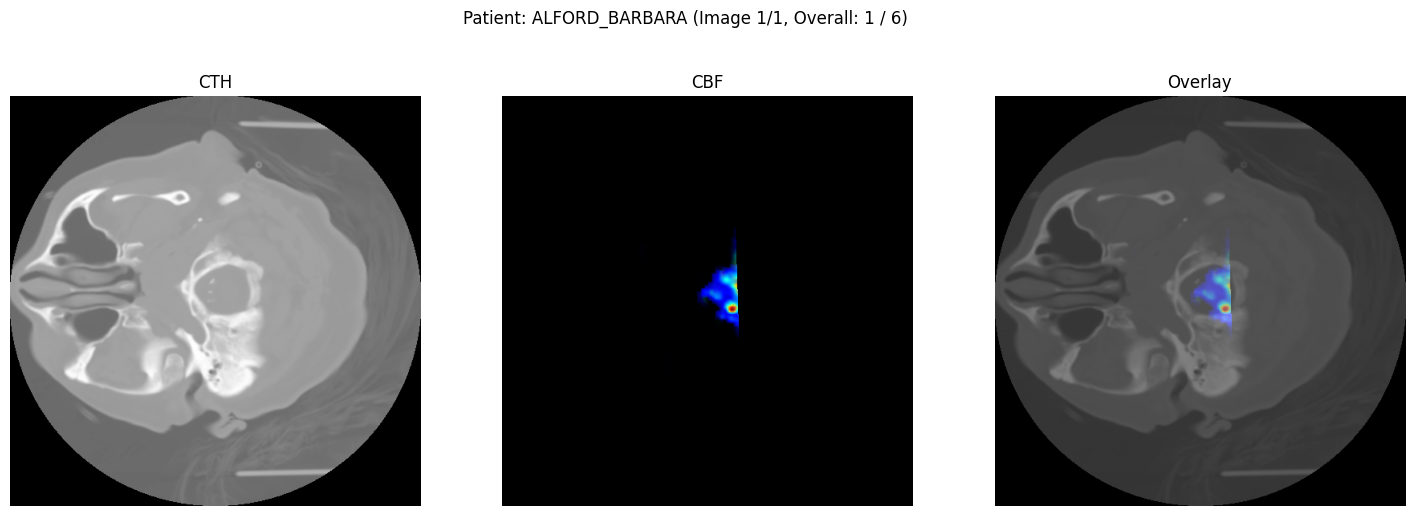

In [9]:
import os
import SimpleITK as sitk
import numpy as np
from PIL import Image
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def nifti_to_png_slices(input_dir, output_dir):
    # Ensure output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Iterate through all .nii files in the input directory
    for filename in os.listdir(input_dir):
        if filename.endswith('.nii'):
            nifti_path = os.path.join(input_dir, filename)
            base_name = os.path.splitext(filename)[0]

            try:
                # Read the NIFTI file
                image = sitk.ReadImage(nifti_path)
                
                # Log image information
                logging.info(f"Processing {filename}")
                logging.info(f"Image size: {image.GetSize()}")
                logging.info(f"Image pixel type: {image.GetPixelIDTypeAsString()}")
                
                # Convert to numpy array
                array = sitk.GetArrayFromImage(image)
                logging.info(f"Array shape: {array.shape}")

                # Iterate through axial slices
                for i in range(array.shape[0]):  # Assuming axial slices are along the first dimension
                    slice_array = array[i, :, :]

                    # Normalize to 0-255 range
                    slice_min, slice_max = slice_array.min(), slice_array.max()
                    if slice_min == slice_max:
                        # If the slice is constant, just use the constant value
                        slice_array_normalized = np.full_like(slice_array, slice_min, dtype=np.uint8)
                    else:
                        slice_array_normalized = ((slice_array - slice_min) / (slice_max - slice_min) * 255).astype(np.uint8)

                    # Create PIL Image
                    slice_image = Image.fromarray(slice_array_normalized)

                    # Save as PNG
                    output_filename = f"{base_name}_{i+1:06d}.png"
                    output_path = os.path.join(output_dir, output_filename)
                    slice_image.save(output_path)

                logging.info(f"Processed {filename} - saved {array.shape[0]} slices")

            except Exception as e:
                logging.error(f"Error processing {filename}: {str(e)}")

# Define input and output directories
input_dir = r"/mnt/d/CTH_ARCHIVE/CBF_COLORED_NIFIT_NOTEXT_REG/"
output_dir = r"/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/CBF_COLORED_PNG_NOTEXT_REG/"

# Run the conversion
nifti_to_png_slices(input_dir, output_dir)

2024-08-18 12:28:31,182 - INFO - Processing ALFORD_BARBARA.nii
2024-08-18 12:28:31,183 - INFO - Image size: (512, 512, 32)
2024-08-18 12:28:31,183 - INFO - Image pixel type: vector of 32-bit float
2024-08-18 12:28:31,196 - INFO - Array shape: (32, 512, 512, 3)
2024-08-18 12:28:31,551 - INFO - Processed ALFORD_BARBARA.nii - saved 32 slices
2024-08-18 12:28:31,960 - INFO - Processing ALLAH_MAJUSTICE.nii
2024-08-18 12:28:31,961 - INFO - Image size: (512, 512, 32)
2024-08-18 12:28:31,962 - INFO - Image pixel type: vector of 32-bit float
2024-08-18 12:28:31,974 - INFO - Array shape: (32, 512, 512, 3)
2024-08-18 12:28:32,389 - INFO - Processed ALLAH_MAJUSTICE.nii - saved 32 slices
2024-08-18 12:28:32,893 - INFO - Processing BATTLE_MARIA.nii
2024-08-18 12:28:32,893 - INFO - Image size: (512, 680, 31)
2024-08-18 12:28:32,894 - INFO - Image pixel type: vector of 32-bit float
2024-08-18 12:28:32,909 - INFO - Array shape: (31, 680, 512, 3)
2024-08-18 12:28:33,505 - INFO - Processed BATTLE_MARIA.n

In [10]:
import os
import shutil
import random

def split_datasets(tmax_dir, cth_dir, train_a_dir, test_a_dir, train_b_dir, test_b_dir, split_ratio=0.9):
    # Create output directories if they don't exist
    for dir in [train_a_dir, test_a_dir, train_b_dir, test_b_dir]:
        os.makedirs(dir, exist_ok=True)

    # Get all files from TMAX_PNG_REG
    tmax_files = [f for f in os.listdir(tmax_dir) if f.endswith('.png')]

    # Randomly shuffle the files
    random.shuffle(tmax_files)

    # Calculate the split index
    split_index = int(len(tmax_files) * split_ratio)

    # Split the files
    train_files = tmax_files[:split_index]
    test_files = tmax_files[split_index:]

    # Function to copy files
    def copy_files(file_list, src_dir_a, dst_dir_a, src_dir_b, dst_dir_b):
        for file in file_list:
            # Copy TMAX file
            shutil.copy(os.path.join(src_dir_a, file), os.path.join(dst_dir_a, file))
            
            # Copy corresponding CTH file
            cth_file = file  # Assuming the filenames are the same
            if os.path.exists(os.path.join(src_dir_b, cth_file)):
                shutil.copy(os.path.join(src_dir_b, cth_file), os.path.join(dst_dir_b, cth_file))
            else:
                print(f"Warning: Corresponding file {cth_file} not found in {src_dir_b}")

    # Copy training files
    copy_files(train_files, tmax_dir, train_a_dir, cth_dir, train_b_dir)

    # Copy test files
    copy_files(test_files, tmax_dir, test_a_dir, cth_dir, test_b_dir)

    print(f"Split complete. {len(train_files)} files in training set, {len(test_files)} files in test set.")

# Define directories
tmax_dir = r"/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/CBF_COLORED_PNG_NOTEXT_REG"
cth_dir = r"/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_TMAX/CTH_PNG"
train_a_dir = r"/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/train_A"
test_a_dir = r"/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/test_A"
train_b_dir = r"/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/train_B"
test_b_dir = r"/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/test_B"

# Run the splitting process
split_datasets(tmax_dir, cth_dir, train_a_dir, test_a_dir, train_b_dir, test_b_dir)

Split complete. 3018 files in training set, 336 files in test set.


In [12]:
import os
import json

def create_prompt_json(dir_a, dir_b, output_json):
    # Get all PNG files from both directories
    files_a = set(f for f in os.listdir(dir_a) if f.endswith('.png'))
    files_b = set(f for f in os.listdir(dir_b) if f.endswith('.png'))

    # Find common files (in case there are any mismatches)
    common_files = sorted(list(files_a.intersection(files_b)))

    # Create a dictionary with file names as keys and empty strings as values
    prompt_dict = {file: "" for file in common_files}

    # Write the dictionary to a JSON file
    with open(output_json, 'w') as f:
        json.dump(prompt_dict, f, indent=2)

    print(f"Created {output_json} with {len(common_files)} entries.")

# Define directories and output files
train_a_dir = r"/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/train_A"
train_b_dir = r"/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/train_B"
test_a_dir = r"/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/test_A"
test_b_dir = r"/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/test_B"

train_json = r"/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/train_prompts.json"
test_json = r"/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/test_prompts.json"

# Create JSON files for train and test sets
create_prompt_json(train_a_dir, train_b_dir, train_json)
create_prompt_json(test_a_dir, test_b_dir, test_json)

Created /home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/train_prompts.json with 3018 entries.
Created /home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/test_prompts.json with 336 entries.


In [13]:
import os
from PIL import Image
import numpy as np

def convert_grayscale_to_3channel(directory):
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(directory, filename)
            
            with Image.open(file_path) as img:
                # Check if the image is grayscale
                if img.mode == 'L':
                    print(f"Converting {filename} to 3-channel image...")
                    
                    # Convert to numpy array
                    img_array = np.array(img)
                    
                    # Stack the single channel three times to create a 3-channel image
                    rgb_array = np.stack((img_array,)*3, axis=-1)
                    
                    # Create a new image from the 3-channel array
                    rgb_img = Image.fromarray(rgb_array.astype('uint8'), 'RGB')
                    
                    # Save the image, overwriting the original file
                    rgb_img.save(file_path)
                else:
                    print(f"{filename} is already a multi-channel image. Skipping...")

# Directories to process
directories = [
    r"/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/test_B",
    r"/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/train_B"
]

# Process each directory
for directory in directories:
    print(f"Processing directory: {directory}")
    convert_grayscale_to_3channel(directory)
    print(f"Finished processing {directory}")

print("All directories processed.")

Processing directory: /home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/test_B
Converting LASUSA_PETER_ROBERT_000012.png to 3-channel image...
Converting CHOWDHURY_SALMA_K_000020.png to 3-channel image...
Converting RODRIQUEZ_RIVERA_ROQUE_000022.png to 3-channel image...
Converting GARCIA_ABELARDO_000005.png to 3-channel image...
Converting CHEUNG_SIU-LING_LING_WOO_000015.png to 3-channel image...
Converting RODRIQUEZ_RIVERA_ROQUE_000003.png to 3-channel image...
Converting RYAN_MICHAEL_000006.png to 3-channel image...
Converting VANN_ELLIS_W_000032.png to 3-channel image...
Converting COOPER_SUSAN_000015.png to 3-channel image...
Converting MORENO_JORGE_000013.png to 3-channel image...
Converting GONZALEZ_FERNANDO_000021.png to 3-channel image...
Converting RAMIREZ_ELIZABETH_000032.png to 3-channel image...
Converting TOUATI_MOHAMED_000075.png to 3-channel image...
Converting GOBLE_TAMMY_000023.png to 3-channel image...
Converting ROBINSON_GENEVA_D_000003.png to 3-channel image...

In [4]:
import os
import numpy as np
from PIL import Image
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity

def calculate_metrics(output_dir, ground_truth_dir):
    mse_values = []
    psnr_values = []
    ssim_values = []
    
    for filename in os.listdir(output_dir):
        if filename.lower().endswith('.png'):
            output_path = os.path.join(output_dir, filename)
            ground_truth_path = os.path.join(ground_truth_dir, filename)
            
            if os.path.exists(ground_truth_path):
                # Open images
                output_img = np.array(Image.open(output_path).convert('RGB'))
                ground_truth_img = np.array(Image.open(ground_truth_path).convert('RGB'))
                
                # Ensure images have the same shape
                if output_img.shape != ground_truth_img.shape:
                    print(f"Shape mismatch for {filename}. Skipping.")
                    continue
                
                # Calculate MSE
                mse = mean_squared_error(ground_truth_img, output_img)
                mse_values.append(mse)
                
                # Calculate PSNR
                psnr = peak_signal_noise_ratio(ground_truth_img, output_img, data_range=255)
                psnr_values.append(psnr)
                
                # Calculate SSIM
                ssim = structural_similarity(ground_truth_img, output_img, channel_axis=2, data_range=255)
                ssim_values.append(ssim)
                
                print(f"Metrics for {filename}:")
                print(f"  MSE: {mse:.4f}")
                print(f"  PSNR: {psnr:.4f} dB")
                print(f"  SSIM: {ssim:.4f}")
            else:
                print(f"Ground truth file not found for {filename}. Skipping.")
    
    if mse_values and psnr_values and ssim_values:
        average_mse = np.mean(mse_values)
        average_psnr = np.mean(psnr_values)
        average_ssim = np.mean(ssim_values)
        print(f"\nAverage Metrics:")
        print(f"  MSE: {average_mse:.4f}")
        print(f"  PSNR: {average_psnr:.4f} dB")
        print(f"  SSIM: {average_ssim:.4f}")
    else:
        print("No valid image pairs found for metric calculation.")

# Set your paths
output_dir = "/home/nicholasjprimiano/ML/img2img-turbo/output/pix2pix_turbo/CTH_TMAX_COLOR/"
ground_truth_dir = "/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_TMAX/test_B"

# Calculate metrics
calculate_metrics(output_dir, ground_truth_dir)

Metrics for PERLMUTTER_JULES_000024.png:
  MSE: 1412.8769
  PSNR: 16.6298 dB
  SSIM: 0.8893
Metrics for SCOUFARAS_DESPINA_000028.png:
  MSE: 1262.2116
  PSNR: 17.1195 dB
  SSIM: 0.9117
Shape mismatch for MCGIVNEY_DOROTHY_000025.png. Skipping.
Shape mismatch for SINGLETARY_DONALD_000004.png. Skipping.
Metrics for RODRIQUEZ_RIVERA_ROQUE_000003.png:
  MSE: 0.0160
  PSNR: 66.1006 dB
  SSIM: 0.9999
Metrics for RAMIREZ_ANGELA_000022.png:
  MSE: 1422.2723
  PSNR: 16.6010 dB
  SSIM: 0.8901
Metrics for DAMBOISE_JACQUES_J_000005.png:
  MSE: 1223.5509
  PSNR: 17.2546 dB
  SSIM: 0.9220
Shape mismatch for SGARLATO_SANTO_000004.png. Skipping.
Metrics for FILION_JULIO_000028.png:
  MSE: 1148.3432
  PSNR: 17.5301 dB
  SSIM: 0.9519
Shape mismatch for GARCIA_ARTURO_000014.png. Skipping.
Shape mismatch for ELISA-WRIGHT_KANZADER_000023.png. Skipping.
Metrics for RAMIREZ_ELIZABETH_000005.png:
  MSE: 1596.8764
  PSNR: 16.0981 dB
  SSIM: 0.8414
Shape mismatch for LAQUERCIA_THEODORE_000011.png. Skipping.
Metr

In [3]:
import os
import numpy as np
from PIL import Image
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from scipy.linalg import sqrtm
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input

def calculate_metrics(output_dir, ground_truth_dir):
    mse_values = []
    psnr_values = []
    ssim_values = []
    output_images = []
    ground_truth_images = []
    
    for filename in os.listdir(output_dir):
        if filename.lower().endswith('.png'):
            output_path = os.path.join(output_dir, filename)
            ground_truth_path = os.path.join(ground_truth_dir, filename)
            
            if os.path.exists(ground_truth_path):
                # Open images
                output_img = np.array(Image.open(output_path).convert('RGB'))
                ground_truth_img = np.array(Image.open(ground_truth_path).convert('RGB'))
                
                # Ensure images have the same shape
                if output_img.shape != ground_truth_img.shape:
                    print(f"Shape mismatch for {filename}. Skipping.")
                    continue
                
                # Calculate MSE
                mse = mean_squared_error(ground_truth_img, output_img)
                mse_values.append(mse)
                
                # Calculate PSNR
                psnr = peak_signal_noise_ratio(ground_truth_img, output_img, data_range=255)
                psnr_values.append(psnr)
                
                # Calculate SSIM
                ssim = structural_similarity(ground_truth_img, output_img, channel_axis=2, data_range=255)
                ssim_values.append(ssim)
                
                # Store images for FID calculation
                output_images.append(output_img)
                ground_truth_images.append(ground_truth_img)
                
                print(f"Metrics for {filename}:")
                print(f"  MSE: {mse:.4f}")
                print(f"  PSNR: {psnr:.4f} dB")
                print(f"  SSIM: {ssim:.4f}")
            else:
                print(f"Ground truth file not found for {filename}. Skipping.")
    
    # Calculate FID
    if output_images and ground_truth_images:
        fid_value = calculate_fid(output_images, ground_truth_images)
        print(f"\nFID: {fid_value:.4f}")
    
    if mse_values and psnr_values and ssim_values:
        average_mse = np.mean(mse_values)
        average_psnr = np.mean(psnr_values)
        average_ssim = np.mean(ssim_values)
        print(f"\nAverage Metrics:")
        print(f"  MSE: {average_mse:.4f}")
        print(f"  PSNR: {average_psnr:.4f} dB")
        print(f"  SSIM: {average_ssim:.4f}")
    else:
        print("No valid image pairs found for metric calculation.")

def calculate_fid(output_images, ground_truth_images):
    # Load the InceptionV3 model
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    
    # Prepare the images
    output_images_resized = np.array([np.array(Image.fromarray(img).resize((299, 299))) for img in output_images])
    ground_truth_images_resized = np.array([np.array(Image.fromarray(img).resize((299, 299))) for img in ground_truth_images])
    
    # Preprocess images
    output_images_resized = preprocess_input(output_images_resized)
    ground_truth_images_resized = preprocess_input(ground_truth_images_resized)
    
    # Get features
    output_features = model.predict(output_images_resized)
    ground_truth_features = model.predict(ground_truth_images_resized)
    
    # Calculate mean and covariance for both sets of features
    mu1, sigma1 = np.mean(output_features, axis=0), np.cov(output_features, rowvar=False)
    mu2, sigma2 = np.mean(ground_truth_features, axis=0), np.cov(ground_truth_features, rowvar=False)
    
    # Calculate FID
    diff = mu1 - mu2
    covmean = sqrtm(sigma1.dot(sigma2))
    
    # Numerical stability check
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    
    fid_value = diff.dot(diff) + np.trace(sigma1 + sigma2 - 2 * covmean)
    return fid_value

# Set your paths
output_dir = "/home/nicholasjprimiano/ML/img2img-turbo/output/pix2pix_turbo/CTH_TMAX_COLOR/"
ground_truth_dir = "/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_TMAX/test_B"

# Calculate metrics
calculate_metrics(output_dir, ground_truth_dir)


2024-08-14 07:45:34.988679: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 07:45:35.040655: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 07:45:35.055425: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 07:45:35.153006: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 07:45:35.978897: W tensorflow/compiler/tf2

Metrics for PERLMUTTER_JULES_000024.png:
  MSE: 1412.8769
  PSNR: 16.6298 dB
  SSIM: 0.8893
Metrics for SCOUFARAS_DESPINA_000028.png:
  MSE: 1262.2116
  PSNR: 17.1195 dB
  SSIM: 0.9117
Shape mismatch for MCGIVNEY_DOROTHY_000025.png. Skipping.
Shape mismatch for SINGLETARY_DONALD_000004.png. Skipping.
Metrics for RODRIQUEZ_RIVERA_ROQUE_000003.png:
  MSE: 0.0160
  PSNR: 66.1006 dB
  SSIM: 0.9999
Metrics for RAMIREZ_ANGELA_000022.png:
  MSE: 1422.2723
  PSNR: 16.6010 dB
  SSIM: 0.8901
Metrics for DAMBOISE_JACQUES_J_000005.png:
  MSE: 1223.5509
  PSNR: 17.2546 dB
  SSIM: 0.9220
Shape mismatch for SGARLATO_SANTO_000004.png. Skipping.
Metrics for FILION_JULIO_000028.png:
  MSE: 1148.3432
  PSNR: 17.5301 dB
  SSIM: 0.9519
Shape mismatch for GARCIA_ARTURO_000014.png. Skipping.
Shape mismatch for ELISA-WRIGHT_KANZADER_000023.png. Skipping.
Metrics for RAMIREZ_ELIZABETH_000005.png:
  MSE: 1596.8764
  PSNR: 16.0981 dB
  SSIM: 0.8414
Shape mismatch for LAQUERCIA_THEODORE_000011.png. Skipping.
Metr

I0000 00:00:1723635951.642375   29763 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:53:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723635951.746474   29763 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:53:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723635951.746534   29763 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:53:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723635951.748294   29763 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:53:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1723635951.748341   29763 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:53:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


I0000 00:00:1723635957.933020   30443 service.cc:146] XLA service 0x7fe7a4254950 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723635957.933053   30443 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4090, Compute Capability 8.9
2024-08-14 07:45:58.001156: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-14 07:45:58.462449: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
2024-08-14 07:45:58.701016: W external/local_xla/xla/stream_executor/gpu/redzone_allocator_kernel_cuda.cc:136] NOT_FOUND: Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /home/nicholasjprimiano/anaconda3/envs/img2img-turbo/bin/ptxas, /home/nicholasjprimiano/.vscode-server/bin/eaa41d57266683296de7d118f574d0c2652e1fc4/bin/remote-cli/ptx

NotFoundError: Graph execution error:

Detected at node StatefulPartitionedCall defined at (most recent call last):
  File "/home/nicholasjprimiano/anaconda3/envs/img2img-turbo/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/home/nicholasjprimiano/anaconda3/envs/img2img-turbo/lib/python3.10/runpy.py", line 86, in _run_code

  File "/home/nicholasjprimiano/.local/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/nicholasjprimiano/.local/lib/python3.10/site-packages/traitlets/config/application.py", line 1043, in launch_instance

  File "/home/nicholasjprimiano/.local/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 725, in start

  File "/home/nicholasjprimiano/.local/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start

  File "/home/nicholasjprimiano/anaconda3/envs/img2img-turbo/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/home/nicholasjprimiano/anaconda3/envs/img2img-turbo/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/home/nicholasjprimiano/anaconda3/envs/img2img-turbo/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/home/nicholasjprimiano/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 513, in dispatch_queue

  File "/home/nicholasjprimiano/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 502, in process_one

  File "/home/nicholasjprimiano/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 409, in dispatch_shell

  File "/home/nicholasjprimiano/.local/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request

  File "/home/nicholasjprimiano/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/nicholasjprimiano/.local/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 540, in run_cell

  File "/home/nicholasjprimiano/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2961, in run_cell

  File "/home/nicholasjprimiano/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3016, in _run_cell

  File "/home/nicholasjprimiano/.local/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/nicholasjprimiano/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3221, in run_cell_async

  File "/home/nicholasjprimiano/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3400, in run_ast_nodes

  File "/home/nicholasjprimiano/.local/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3460, in run_code

  File "/tmp/ipykernel_29763/454813621.py", line 105, in <module>

  File "/tmp/ipykernel_29763/454813621.py", line 55, in calculate_metrics

  File "/tmp/ipykernel_29763/454813621.py", line 82, in calculate_fid

  File "/home/nicholasjprimiano/anaconda3/envs/img2img-turbo/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/home/nicholasjprimiano/anaconda3/envs/img2img-turbo/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 512, in predict

  File "/home/nicholasjprimiano/anaconda3/envs/img2img-turbo/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

Couldn't find a suitable version of ptxas. The following locations were considered: ./cuda_sdk_lib/bin/ptxas, /home/nicholasjprimiano/anaconda3/envs/img2img-turbo/bin/ptxas, /home/nicholasjprimiano/.vscode-server/bin/eaa41d57266683296de7d118f574d0c2652e1fc4/bin/remote-cli/ptxas, /home/nicholasjprimiano/.local/bin/ptxas, /usr/local/cuda/bin/ptxas, /home/nicholasjprimiano/anaconda3/envs/img2img-turbo/bin/ptxas, /home/nicholasjprimiano/anaconda3/condabin/ptxas, /usr/local/sbin/ptxas, /usr/local/bin/ptxas, /usr/sbin/ptxas, /usr/bin/ptxas, /sbin/ptxas, /bin/ptxas, /usr/games/ptxas, /usr/local/games/ptxas, /usr/lib/wsl/lib/ptxas, /mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.8/bin/ptxas, /mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.8/libnvvp/ptxas, /mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v10.0/bin/ptxas, /mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v10.0/libnvvp/ptxas, /mnt/c/Users/nprim/Downloads/ants-2.5.1-windows-2022-X64-VS2019/ants-2.5.1/bin/ptxas, /mnt/c/Program Files/NVIDIA Corporation/Nsight Compute 2022.3.0/ptxas, /mnt/c/Program Files/dotnet/ptxas, /mnt/c/Program Files/NVIDIA Corporation/NVIDIA App/NvDLISR/ptxas, /mnt/c/Program Files/Meld/ptxas, /mnt/c/Program Files (x86)/NVIDIA Corporation/PhysX/Common/ptxas, /mnt/c/Program Files/PowerShell/7/ptxas, /mnt/c/Program Files/Git/cmd/ptxas, /mnt/c/Users/nprim/Downloads/cudnn-10.0-windows10-x64-v7.6.4.38/cuda/bin/ptxas, /mnt/c/Users/nprim/AppData/Local/Programs/Python/Launcher/ptxas, /mnt/c/Users/nprim/AppData/Local/Programs/Python/Python311/Scripts/ptxas, /mnt/c/Users/nprim/AppData/Local/Programs/Python/Python311/ptxas, /mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v10.0/ptxas, /mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v10.0/include/lib/x64/ptxas, /mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v10.0/include/ptxas, /mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v10.0/extras/CUPTI/lib64/ptxas, /mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v10.0/bin/ptxas, /mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.7/ptxas, /mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.7/bin/ptxas, /mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.7/include/lib/x64/ptxas, /mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.7/include/ptxas, /mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v11.7/extras/CUPTI/lib64/ptxas, /mnt/c/Program Files/NVIDIA Corporation/cudnn-11.1-windows-x64-v8.1.0.77/cuda/bin/ptxas, /mnt/c/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Auxiliary/Build/vcvars64.bat/ptxas, /mnt/c/Users/nprim/scoop/shims/ptxas, /mnt/c/Users/nprim/AppData/Local/Programs/Python/Python37/Scripts/ptxas, /mnt/c/Users/nprim/AppData/Local/Programs/Python/Python37/ptxas, /mnt/c/Users/nprim/AppData/Local/Programs/Python/Python39/Scripts/ptxas, /mnt/c/Users/nprim/AppData/Local/Programs/Python/Python39/ptxas, /mnt/c/Users/nprim/AppData/Local/Microsoft/WindowsApps/ptxas, /mnt/c/Users/nprim/AppData/Local/Programs/Microsoft VS Code/bin/ptxas, /mnt/c/Users/nprim/AppData/Local/Programs/Python/Python37/Scripts/ptxas, /mnt/c/Program Files/NVIDIA GPU Computing Toolkit/CUDA/v10.0/bin/cudart64_100.dll/ptxas, /mnt/c/cudnn-windows-x86_64-8.3.3.40_cuda10.2-archive/bin/cudnn64_8.dll/ptxas, /mnt/c/Program Files/Vim/vim82/vim.exe/ptxas, /mnt/c/Users/nprim/.dotnet/tools/ptxas, /mnt/c/Users/nprim/AppData/Local/Microsoft/WindowsApps/ptxas, /mnt/c/Users/nprim/AppData/Local/Packages/PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0/LocalCache/local-packages/Python39/Scripts/ptxas, /mnt/c/Program Files/Graphviz/bin/ptxas, /mnt/c/Windows/System32/ptxas, /mnt/c/Users/nprim/Miniconda3/ptxas, /mnt/c/Users/nprim/Miniconda3/Scripts/ptxas, /mnt/c/Users/nprim/.dotnet/tools/ptxas, /snap/bin/ptxas, /usr/local/cuda-12.3/bin/ptxas, /usr/local/cuda/bin/ptxas, /home/nicholasjprimiano/anaconda3/envs/img2img-turbo/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc/bin/ptxas, /home/nicholasjprimiano/anaconda3/envs/img2img-turbo/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc/bin/ptxas
	 [[{{node StatefulPartitionedCall}}]] [Op:__inference_one_step_on_data_distributed_6309]

In [ ]:
import os
import json
from PIL import Image
import numpy as np

def is_mostly_black(image_path, threshold=0.995):
    with Image.open(image_path) as img:
        img_array = np.array(img)
        if len(img_array.shape) == 3:  # RGB image
            return np.mean(img_array == 0) >= threshold
        else:  # Grayscale image
            return np.mean(img_array == 0) >= threshold

def remove_files_and_update_json(dir_a, dir_b, json_file):
    with open(json_file, 'r') as f:
        prompts = json.load(f)

    files_to_remove = []

    for filename in os.listdir(dir_a):
        if filename.lower().endswith('.png'):
            file_path_a = os.path.join(dir_a, filename)
            file_path_b = os.path.join(dir_b, filename)

            if is_mostly_black(file_path_a):
                print(f"Removing {filename}")
                os.remove(file_path_a)
                if os.path.exists(file_path_b):
                    os.remove(file_path_b)
                files_to_remove.append(filename)

    # Update JSON
    for file in files_to_remove:
        prompts.pop(file, None)

    with open(json_file, 'w') as f:
        json.dump(prompts, f, indent=2)

    print(f"Removed {len(files_to_remove)} files and updated {json_file}")

# Paths
test_a = "/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/test_A"
test_b = "/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_CBF/test_B"
train_a = "/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_TMAX/train_A"
train_b = "/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_TMAX/train_B"
test_json = "/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_TMAX/test_prompts.json"
train_json = "/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_TMAX/train_prompts.json"

# Process test and train sets
remove_files_and_update_json(test_a, test_b, test_json)
remove_files_and_update_json(train_a, train_b, train_json)

print("Processing complete.")

In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm

def apply_clahe(image_path, output_path, clip_limit=2.0, tile_grid_size=(8, 8)):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    
    # Create a mask for the brain tissue (assuming brain tissue is not black)
    brain_mask = image > 0

    # Apply CLAHE to the brain tissue
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    clahe_image = clahe.apply(image)
    
    # Apply the mask to keep the background black
    final_image = np.where(brain_mask, clahe_image, 0)

    cv2.imwrite(output_path, final_image)

def process_directory(input_dir, output_dir, clip_limit=2.0, tile_grid_size=(8, 8)):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for filename in tqdm(os.listdir(input_dir)):
        if filename.endswith('.png'):
            input_path = os.path.join(input_dir, filename)
            output_path = os.path.join(output_dir, filename)
            apply_clahe(input_path, output_path, clip_limit, tile_grid_size)

# Paths to your datasets
input_dir_train = '/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_TMAX/train_A'
output_dir_train = '/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_TMAX/train_A_enhanced'

input_dir_test = '/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_TMAX/test_A'
output_dir_test = '/home/nicholasjprimiano/ML/img2img-turbo/data/CTH_TMAX/test_A_enhanced'

# Process the directories
process_directory(input_dir_train, output_dir_train)
process_directory(input_dir_test, output_dir_test)


In [8]:
import os
import pydicom
import numpy as np
import SimpleITK as sitk

def convert_dicom_series_to_nii(dicom_dir, output_dir):
    # Get patient name and ID from the directory name
    patient_name_id = os.path.basename(dicom_dir)

    # Load DICOM series
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(dicom_dir)
    reader.SetFileNames(dicom_names)

    # Read the image series
    image = reader.Execute()

    # Ensure the output image has RGB channels
    image_array = sitk.GetArrayFromImage(image)  # shape: (slices, height, width)
    if image_array.ndim == 3:  # Single channel, need to convert to RGB
        rgb_image_array = np.stack((image_array,) * 3, axis=-1)  # shape: (slices, height, width, 3)
    else:
        rgb_image_array = image_array

    # Resize to 256x256 if necessary
    original_size = rgb_image_array.shape[1:3]
    if original_size != (256, 256):
        resized_image_array = np.zeros((rgb_image_array.shape[0], 256, 256, 3), dtype=rgb_image_array.dtype)
        for i in range(rgb_image_array.shape[0]):
            slice_image = sitk.GetImageFromArray(rgb_image_array[i])
            resized_slice = sitk.Resample(slice_image, [256, 256], sitk.Transform(), sitk.sitkLinear)
            resized_image_array[i] = sitk.GetArrayFromImage(resized_slice)
    else:
        resized_image_array = rgb_image_array

    # Create SimpleITK image from RGB array
    rgb_image = sitk.GetImageFromArray(resized_image_array)
    rgb_image.CopyInformation(image)  # Preserve orientation, direction, origin

    # Save as .nii file
    output_file = os.path.join(output_dir, f"{patient_name_id}.nii")
    sitk.WriteImage(rgb_image, output_file)

    print(f"Converted {patient_name_id} to {output_file}")

def process_all_dicom_series(base_dir, output_dir):
    # Recursively find all patient directories
    for root, dirs, files in os.walk(base_dir):
        if any(file.endswith('.dcm') for file in files):
            convert_dicom_series_to_nii(root, output_dir)

# Directory paths
base_dir = "/mnt/d/CTH_archive/CBF_COLORED"
output_dir = "/mnt/d/CTH_archive/CBF_COLORED_NIFTI"

# Convert all series in the base directory
process_all_dicom_series(base_dir, output_dir)


Converted ALFORD_BARBARA 4024996 to /mnt/d/CTH_archive/CBF_COLORED_NIFTI/ALFORD_BARBARA 4024996.nii
Converted ALLAH_MAJUSTICE 2621774 to /mnt/d/CTH_archive/CBF_COLORED_NIFTI/ALLAH_MAJUSTICE 2621774.nii
Converted BATTLE_MARIA 8399298 to /mnt/d/CTH_archive/CBF_COLORED_NIFTI/BATTLE_MARIA 8399298.nii
Converted BAUM_ROBERT 6035108 to /mnt/d/CTH_archive/CBF_COLORED_NIFTI/BAUM_ROBERT 6035108.nii
Converted BILLIPS_JAMES 6272788 to /mnt/d/CTH_archive/CBF_COLORED_NIFTI/BILLIPS_JAMES 6272788.nii
Converted BOGER_DAVID_S 2532249 to /mnt/d/CTH_archive/CBF_COLORED_NIFTI/BOGER_DAVID_S 2532249.nii
Converted CAMPAGNA_HARRY_D E304749 to /mnt/d/CTH_archive/CBF_COLORED_NIFTI/CAMPAGNA_HARRY_D E304749.nii
Converted CARDIN_PAUL E570140 to /mnt/d/CTH_archive/CBF_COLORED_NIFTI/CARDIN_PAUL E570140.nii
Converted CHANG_WAH_KONG 5708968 to /mnt/d/CTH_archive/CBF_COLORED_NIFTI/CHANG_WAH_KONG 5708968.nii
Converted CHEN_QIAOYING F262455 to /mnt/d/CTH_archive/CBF_COLORED_NIFTI/CHEN_QIAOYING F262455.nii
Converted CHEN_X